In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import sys
import multivelo as mv
import matplotlib.pyplot as plt
import requests


In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [8]:

rna_url = "https://figshare.com/ndownloader/files/40064320"
atac_url = "https://figshare.com/ndownloader/files/40064311"

rna_path = "data/datasets/3423_MV_2_adata_rna_postpro.h5ad"
atac_path = "data/datasets/3423_MV_2_adata_atac_postpro.h5ad"

In [9]:
adata_rna = sc.read(rna_path, backup_url=rna_url)
adata_atac = sc.read(atac_path, backup_url=atac_url)

In [3]:
h5ad_url = "https://figshare.com/ndownloader/files/40066924"
adata_result = sc.read("data/datasets/multivelo_result_fig5.h5ad", backup_url = h5ad_url)

  0%|          | 0.00/1.05G [00:00<?, ?B/s]

In [19]:
adata_atac

AnnData object with n_obs × n_vars = 11605 × 1000
    obs: 'n_counts', 'leiden'
    layers: 'Mc'
    obsp: 'connectivities'

In [26]:
## recover the celllines 
hsc_check = adata_rna.obs['leiden'] == "HSC"
mpp_check = adata_rna.obs['leiden'] == "MPP"
lmpp_check = adata_rna.obs['leiden'] == "LMPP"
gmp_check = adata_rna.obs['leiden'] == "GMP"

# myeloid_check = (mpp_check | lmpp_check | gmp_check)
myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)

myeloid_rna_data = adata_rna[myeloid_check, :].copy()
myeloid_atac_data = adata_atac[myeloid_check, :].copy()


## recover the celllines 



recovering dynamics (using 1/20 cores)


  0%|          | 0/418 [00:00<?, ?gene/s]

    finished (0:09:39) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:00:41) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


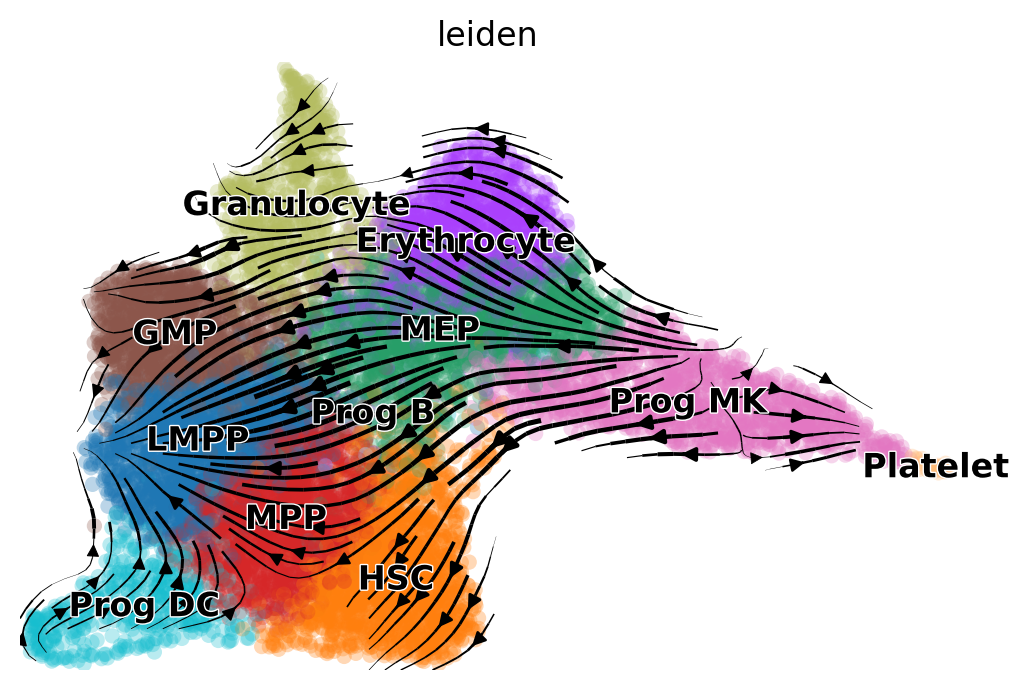

In [10]:
## whole dataset
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='leiden')

## myeloid celllines
# scv.tl.recover_dynamics(myeloid_rna_data)
# scv.tl.velocity(myeloid_rna_data, mode="dynamical")
# scv.tl.velocity_graph(myeloid_rna_data, n_jobs=1)
# scv.tl.latent_time(myeloid_rna_data)
# scv.pl.velocity_embedding_stream(myeloid_rna_data, basis='umap', color='leiden')





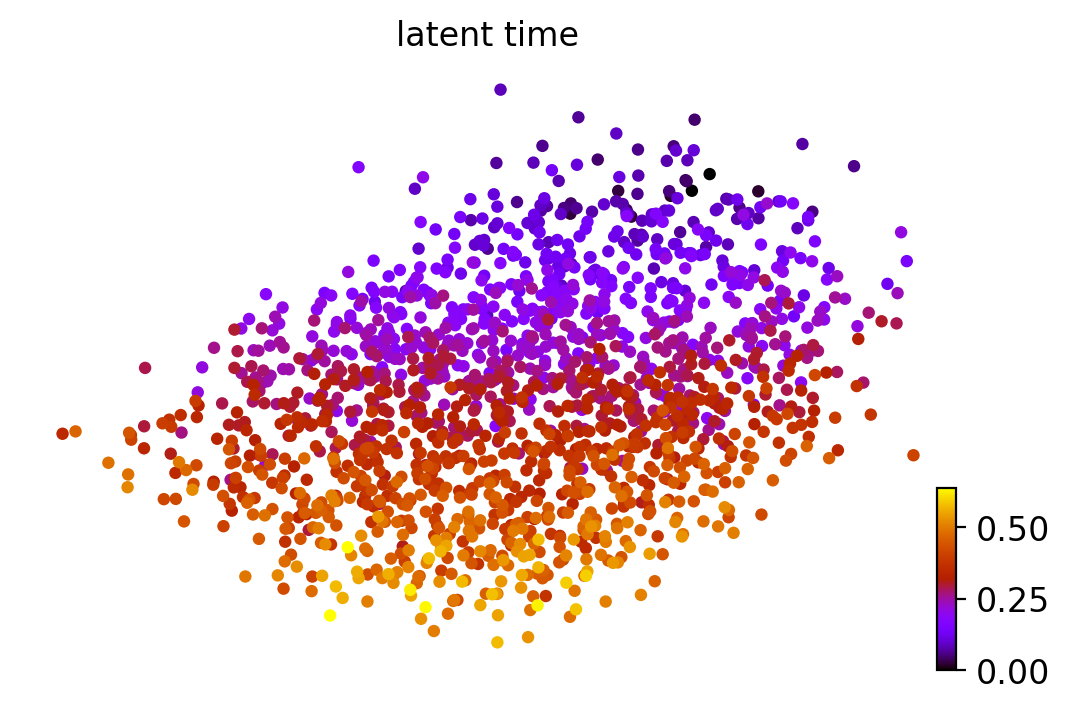

In [33]:
lmpp_check = myeloid_rna_data.obs['leiden'] == "MPP"

scv.pl.scatter(myeloid_rna_data[lmpp_check,:], color='latent_time', color_map='gnuplot', size=80)


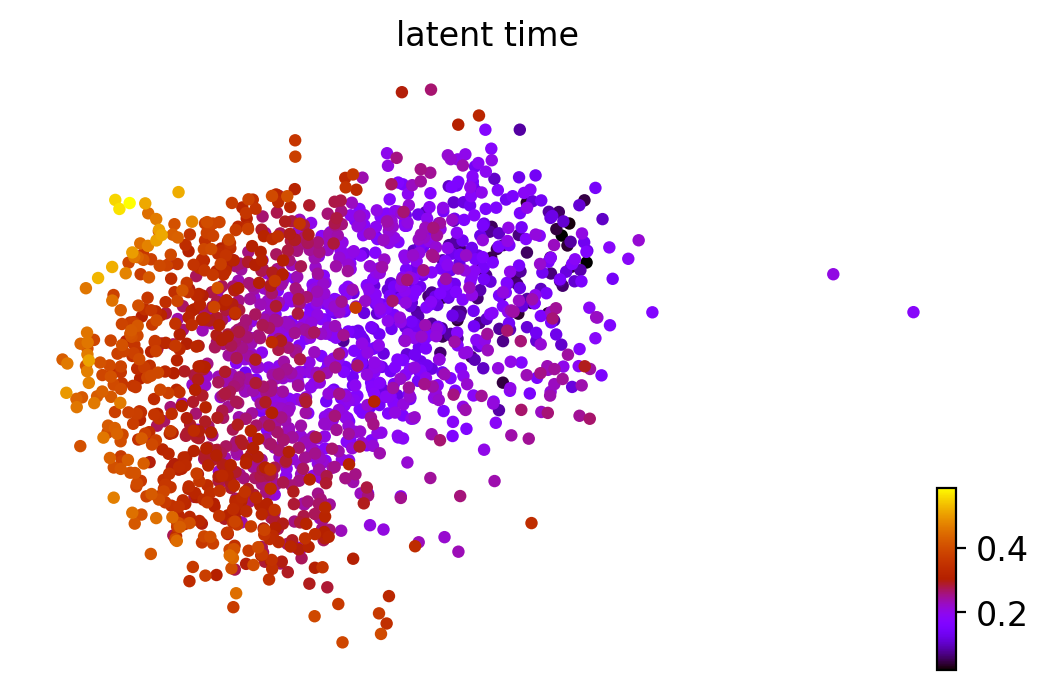

In [34]:
lmpp_check = myeloid_rna_data.obs['leiden'] == "LMPP"

scv.pl.scatter(myeloid_rna_data[lmpp_check,:], color='latent_time', color_map='gnuplot', size=80)

In [18]:
# This will take a while. Parallelization is high recommended.
## whole dataset

# adata_result = mv.recover_dynamics_chrom(adata_rna,
#                                         adata_atac,
#                                         max_iter=5,
#                                         init_mode="invert",
#                                         verbose=False,
#                                         parallel=True,
#                                         n_jobs = 10,
#                                         save_plot=False,
#                                         rna_only=False,
#                                         fit=True,
#                                         n_anchors=500,
#                                         extra_color_key='leiden'
#                                         )
## myeloid celllines
adata_result = mv.recover_dynamics_chrom(myeloid_rna_data,
                                        myeloid_atac_data,
                                        max_iter=5,
                                        init_mode="invert",
                                        verbose=False,
                                        parallel=True,
                                        n_jobs = 15,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500,
                                        extra_color_key='leiden'
                                        )                                        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
mv.set_velocity_genes(adata_result, likelihood_lower=0.02)
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/20 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:01:12) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:03) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


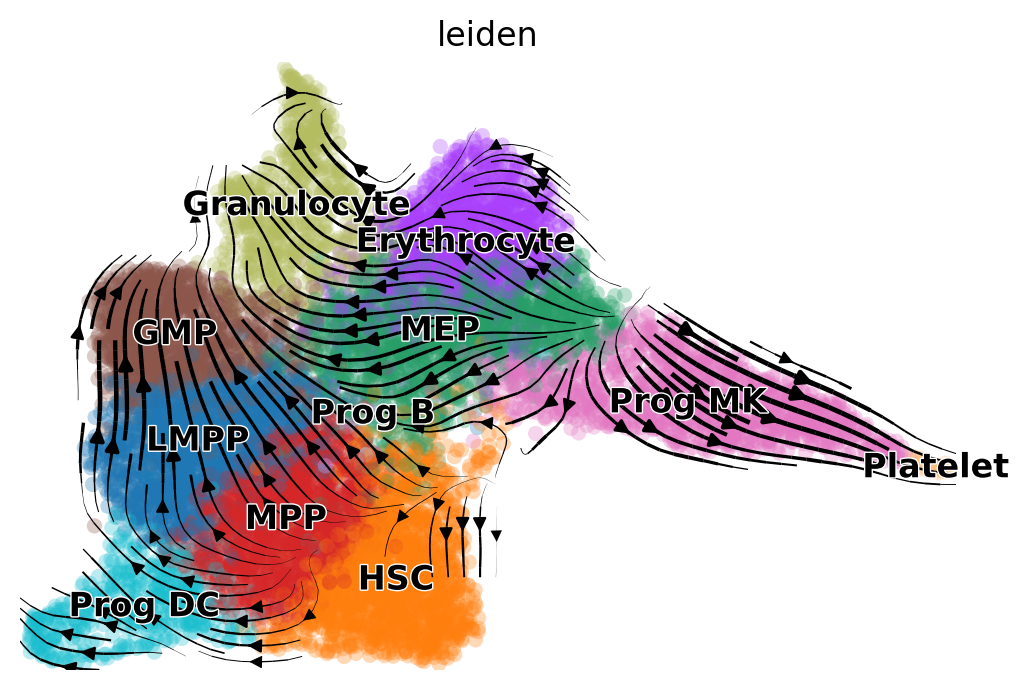

In [5]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='leiden', show=True)


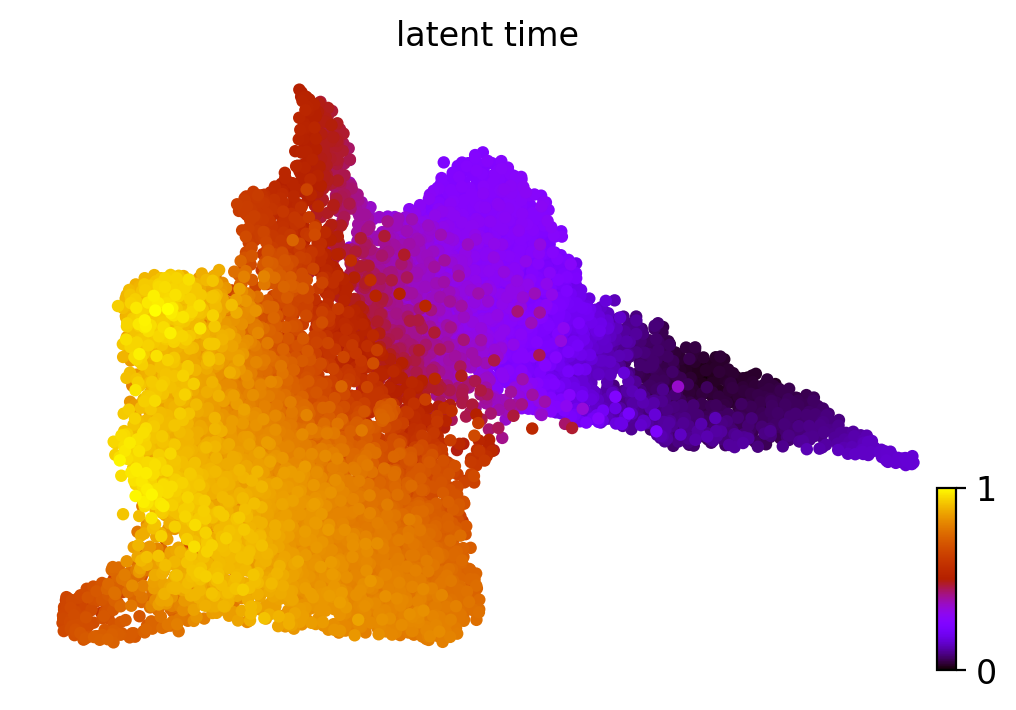

In [6]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)


In [20]:
adata_result.write("Multivelo/myeloid_result_Bone_Marrow_fig5.h5ad")

In [15]:
adata_rna.obs["latent_time" ] = adata_result.obs["latent_time"]

In [6]:
adata_rna.obs

,n_counts,n_genes_by_counts,total_counts,initial_size_spliced,initial_size_unspliced,initial_size,S_score,G2M_score,phase,fraction_u,leiden,root_prediction,total_s,total_u,total_Ms,total_Mu,velocity_self_transition,root_cells,end_points,velocity_pseudotime,latent_time
AAACAGCCAAACCTTG-1,4250.775879,1497,3384.0,3355,1502,3355.0,-0.639016,-0.084668,G1,0.337037,Granulocyte,1802.832520,657.750183,334.387451,599.145020,329.588806,0.453487,0.0,1.996296e-06,0.806096,0.577731
AAACAGCCACCCTCAC-1,4271.195801,1673,3251.0,3222,1803,3222.0,0.426831,-0.269810,S,0.374933,Erythrocyte,960.862976,382.897614,229.672745,401.778961,242.530289,0.449400,0.0,6.061452e-03,0.782181,0.348676
AAACATGCAATCGCAC-1,4257.953125,1652,3272.0,3231,1765,3231.0,-0.808050,-0.224254,G1,0.428079,Erythrocyte,959.728088,372.419708,278.753510,377.729889,226.881531,0.165110,0.0,2.421287e-03,0.763962,0.302457
AAACATGCACAGCCTG-1,4250.682129,3637,10265.0,10148,3614,10148.0,0.544093,0.360281,S,0.329166,Prog MK,1003.200989,397.672058,195.130066,408.701752,206.830246,0.069802,0.0,4.055606e-07,0.427085,0.134156
AAACATGCAGAGGCTA-1,4260.723633,1572,3526.0,3495,1683,3495.0,0.403889,-0.431673,S,0.378415,LMPP,895.411560,410.163116,249.702927,395.722778,206.011414,0.366963,0.0,9.093371e-01,0.945834,0.751011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTAAAC-1,4227.182129,1642,3244.0,3198,1635,3198.0,-0.656418,-0.192740,G1,0.399609,HSC,1391.066650,457.763611,304.678864,403.277954,225.133041,0.382353,0.0,1.254103e-02,0.914458,0.693304
TTTGTTGGTGTTGTGA-1,4243.833984,2306,5480.0,5421,2230,5421.0,0.000000,0.031269,G2M,0.403889,MEP,841.123230,358.193726,242.690552,387.106262,230.782501,0.139911,0.0,2.170608e-03,0.806884,0.312588
TTTGTTGGTTACCTGT-1,4257.888184,1664,3310.0,3279,1618,3279.0,0.000000,-0.035174,S,0.351933,MEP,1019.963257,419.959747,228.059326,411.425873,221.325470,0.165974,0.0,2.449812e-05,0.822282,0.410805
TTTGTTGGTTCCGGGA-1,4276.454590,2193,5188.0,5145,1784,5145.0,0.819528,0.012891,S,0.367889,Erythrocyte,797.048218,385.007599,224.075104,381.171356,205.180923,0.104168,0.0,2.165803e-04,0.790988,0.313532


In [17]:
adata_rna.write("data/datasets/3423_MV_2_adata_rna_postpro.h5ad")

## Wrap up the rna and dna data to multi-modal adata

In [18]:
from scipy.sparse import hstack
counts = hstack([adata_rna.X, adata_atac.X])
counts.shape

(11605, 2000)

In [24]:
import anndata as ad
adata_mvi = ad.AnnData(counts)
adata_mvi.obs = adata_rna.obs[["n_counts", "n_genes_by_counts", "total_counts", "latent_time"]]
adata_mvi

AnnData object with n_obs × n_vars = 11605 × 2000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'latent_time'

In [31]:
rnavar = adata_rna.var
rnavar["modality"] = "Gene Expression"
rnavar["feature_types"] = "Gene Expression"
rnavar

,Accession,Chromosome,End,Start,Strand,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,gene_count_corr,means,dispersions,dispersions_norm,highly_variable,mean,std,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes,modality,feature_types
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABAT,ENSG00000183044,16,8784575,8674596,+,272,0.020566,98.057698,288.0,-0.0341,0.020065,0.235853,1.564199,True,2.599235e-11,0.100074,-1.654598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Gene Expression,Gene Expression
ABCA1,ENSG00000165029,9,104928155,104781006,-,245,0.018566,98.250500,260.0,-0.0521,0.020486,0.384934,3.093894,True,-4.566474e-12,0.102217,0.230343,0.032583,0.264273,0.211284,11.921818,1.569288,0.040922,0.029409,1.290426e-01,0.0,0.0,0.315820,0.136548,0.111615,1.987730,2.787348,True,Gene Expression,Gene Expression
ABCC3,ENSG00000108846,17,50692253,50634777,+,108,0.010783,99.228792,151.0,0.0328,0.007360,0.300227,2.224734,True,4.426508e-12,0.059555,0.852556,0.133441,0.127349,0.188361,19.594337,0.849202,0.192472,0.101993,1.032976e-12,0.0,0.0,0.482965,0.939114,0.581029,0.625856,4.161079,False,Gene Expression,Gene Expression
ABCC4,ENSG00000125257,13,95301475,95019835,-,6723,1.259212,51.992288,17634.0,0.1282,0.706090,0.850102,2.344938,True,1.154191e-10,0.572495,0.929723,1.567371,0.216968,0.402972,6.747256,1.199200,2.267737,0.879335,4.151025e-01,0.0,0.0,0.475993,5.256559,2.036918,0.208132,1.725195,True,Gene Expression,Gene Expression
ABHD2,ENSG00000140526,15,89202355,89087459,+,6018,0.726078,57.026564,10168.0,0.1254,0.465707,0.235892,0.812992,True,2.344608e-11,0.439750,0.668581,0.484554,0.741115,0.428397,13.522619,0.310108,0.189726,0.289078,3.114415e-01,0.0,0.0,0.413684,0.541378,0.885483,0.583682,2.055906,True,Gene Expression,Gene Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF727,ENSG00000214652,7,64085339,64045434,+,482,0.036275,96.558126,508.0,-0.0288,0.032576,0.185154,1.043992,True,-1.083400e-12,0.125573,-0.203123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Gene Expression,Gene Expression
ZNF780B,ENSG00000128000,19,40056231,40028260,-,981,0.073693,92.994859,1032.0,-0.0411,0.067083,0.224894,1.451750,True,5.826283e-11,0.178888,-2.378759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Gene Expression,Gene Expression
ZNF783,ENSG00000204946,7,149297302,149262171,+,542,0.040988,96.129677,574.0,-0.0393,0.039113,0.195037,1.145397,True,7.417778e-11,0.138162,-0.886897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Gene Expression,Gene Expression


## Read the atac data row countt


In [50]:
atac_adata = sc.read_10x_mtx("/mnt/data0/halo/multivelo_BM/ATAC", gex_only=False)
atac_adata

AnnData object with n_obs × n_vars = 14895 × 213367
    var: 'gene_ids', 'feature_types'

In [51]:
atac_adata.var.feature_types.unique()

array(['Gene Expression', 'Peaks'], dtype=object)

In [52]:
adata_atac.obs.head()

,n_counts,leiden
AAACAGCCAAACCTTG-1,16447.0,Granulocyte
AAACAGCCACCCTCAC-1,9698.0,Erythrocyte
AAACATGCAATCGCAC-1,16270.0,Erythrocyte
AAACATGCACAGCCTG-1,29317.0,Prog MK
AAACATGCAGAGGCTA-1,7799.0,LMPP


In [60]:
atac_adata = atac_adata[adata_rna.obs.index, :]

In [61]:
atac_adata.obs = adata_rna.obs

In [62]:
atac_adata.var[atac_adata.var.feature_types=="Gene Expression"]

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC141272.1,ENSG00000277836,Gene Expression
AC023491.2,ENSG00000278633,Gene Expression
AC007325.1,ENSG00000276017,Gene Expression
AC007325.4,ENSG00000278817,Gene Expression


In [63]:
atac_adata.var[atac_adata.var.feature_types=="Peaks"]

,gene_ids,feature_types
chr1:9816-10713,chr1:9816-10713,Peaks
chr1:181070-181803,chr1:181070-181803,Peaks
chr1:183970-184799,chr1:183970-184799,Peaks
chr1:186431-187290,chr1:186431-187290,Peaks
chr1:191121-192037,chr1:191121-192037,Peaks
...,...,...
KI270713.1:21418-22293,KI270713.1:21418-22293,Peaks
KI270713.1:25938-26695,KI270713.1:25938-26695,Peaks
KI270713.1:29583-30478,KI270713.1:29583-30478,Peaks
KI270713.1:33246-33817,KI270713.1:33246-33817,Peaks


In [64]:
atac_adata.write_h5ad("multivelo_bonemarrow.h5ad")

In [8]:
## check the dataset
import scvi

path = "/mnt/data0/halo/multivelo_BM/ATAC/multivelo_bonemarrow.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

Global seed set to 0


In [13]:
adata_rna.obs[["latent_time"]]

,latent_time
AAACAGCCAAACCTTG-1,0.577731
AAACAGCCACCCTCAC-1,0.348676
AAACATGCAATCGCAC-1,0.302457
AAACATGCACAGCCTG-1,0.134156
AAACATGCAGAGGCTA-1,0.751011
...,...
TTTGTTGGTGTTAAAC-1,0.693304
TTTGTTGGTGTTGTGA-1,0.312588
TTTGTTGGTTACCTGT-1,0.410805
TTTGTTGGTTCCGGGA-1,0.313532


In [12]:
adata_mvi.obs[["latent_time"]]

,latent_time
AAACAGCCAAACCTTG-1_paired,0.577731
AAACAGCCACCCTCAC-1_paired,0.348676
AAACATGCAATCGCAC-1_paired,0.302457
AAACATGCACAGCCTG-1_paired,0.134156
AAACATGCAGAGGCTA-1_paired,0.751011
...,...
TTTGTTGGTGTTAAAC-1_paired,0.693304
TTTGTTGGTGTTGTGA-1_paired,0.312588
TTTGTTGGTTACCTGT-1_paired,0.410805
TTTGTTGGTTCCGGGA-1_paired,0.313532


In [7]:
# variables for subsetting the AnnData object to just the myeloid lineage
hsc_check = adata_result.obs['leiden'] == "HSC"
mpp_check = adata_result.obs['leiden'] == "MPP"
lmpp_check = adata_result.obs['leiden'] == "LMPP"
gmp_check = adata_result.obs['leiden'] == "GMP"

myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)


# variables for subsetting the AnnData object to just the erythrocyte lineage
erythrocyte_check = adata_result.obs['leiden'] == "Erythrocyte"
mep_check = adata_result.obs['leiden'] == "MEP"
hsc_check = adata_result.obs['leiden'] == "HSC"
progdc_check = adata_result.obs['leiden'] == "ProgDC"

erythroid_check = (erythrocyte_check | mep_check | hsc_check | progdc_check)


# variables for subsetting the AnnData object to just the platelet lineage
platelet_check = adata_result.obs['leiden'] == "Platelet"
progmk_check = adata_result.obs['leiden'] == "Prog MK"
mep_check = adata_result.obs['leiden'] == "MEP"

platelet_lineage_check = (platelet_check | progmk_check | mep_check | hsc_check)

NameError: name 'adata_result' is not defined